# Preparing the data for modeling

###### Dropping columns and assessing multi-collinearity

In [1]:
%tensorflow_version 2.x

In [2]:
# import all required libraried
# For Analysis
import numpy as np
import pandas as pd

# For Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#For Modeling
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV,train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#Hide warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from datetime import datetime

from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
import time

In [5]:
# references to original data
#!wget https://www.dropbox.com/s/jyv6sfic106o0tq/cleaned_data.zip

In [6]:
#!unzip /content/cleaned_data.zip

In [7]:
# import cleaned train and test data
cleaned_train_data=pd.read_csv('/content/cleaned_data/cleaned_train_data.csv')
cleaned_test_data=pd.read_csv('/content/cleaned_data/cleaned_test_data.csv')

In [8]:
cleaned_train_data.shape, cleaned_test_data.shape

((49999, 50), (49999, 49))

In [9]:
test_data=cleaned_test_data.copy()

In [10]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

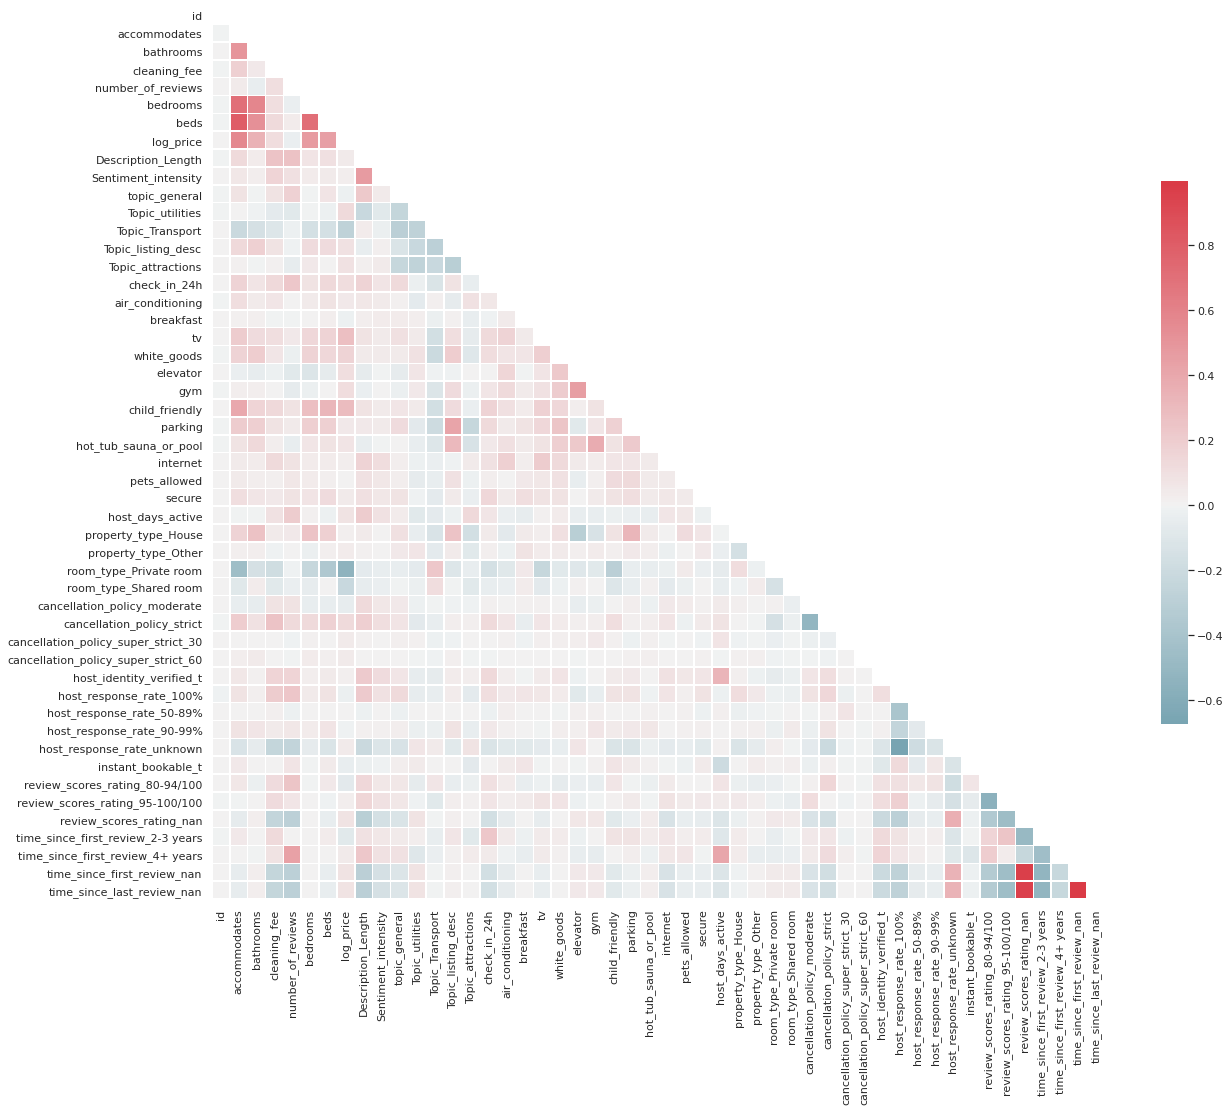

In [11]:
multi_collinearity_heatmap(cleaned_train_data, figsize=(20,20))

In [12]:
# Dropping collinear features in train data
to_drop = ['id','beds',
           'bedrooms',
           'child_friendly', 
           'host_response_rate_unknown',
           'room_type_Private room','time_since_first_review_4+ years',
           'review_scores_rating_nan','time_since_first_review_nan',
           'time_since_last_review_nan','cancellation_policy_super_strict_60']
to_drop.extend(list(cleaned_train_data.columns[cleaned_train_data.columns.str.endswith('nan')]))

cleaned_train_data.drop(to_drop, axis=1, inplace=True)

In [13]:
# Dropping collinear features in test data
to_drop = ['id','beds',
           'bedrooms',
           'child_friendly', 
           'host_response_rate_unknown',
           'room_type_Private room','time_since_first_review_4+ years',
           'review_scores_rating_nan','time_since_first_review_nan',
           'time_since_last_review_nan','cancellation_policy_super_strict_60']
to_drop.extend(list(cleaned_test_data.columns[cleaned_test_data.columns.str.endswith('nan')]))

cleaned_test_data.drop(to_drop, axis=1, inplace=True)

In [22]:
# Separating X and y
X = cleaned_train_data.drop('log_price', axis=1)
y = cleaned_train_data['log_price'].values

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Model Building

  * In this section several machine learning and deep learning models will be built in order to predict an Airbnb listing's price.

# Random Forest -model 1

In [17]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [29]:
clf= RandomForestRegressor(max_depth=10, n_estimators=100)

In [30]:
clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

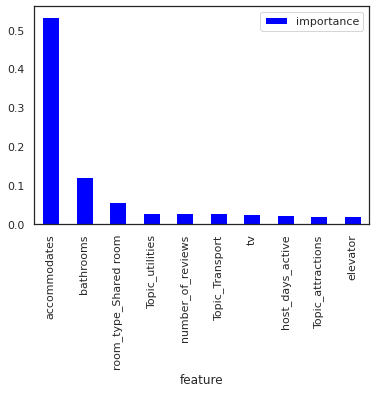

In [33]:
importances = clf.feature_importances_
feat_names = X_train.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar',color='blue')

In [38]:
# Use the model to predict values
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)

print("\nTraining RMSE:", round(np.sqrt(mean_squared_error(y_train, training_preds)),4))
print("Validation RMSE:", round(np.sqrt(mean_squared_error(y_test, val_preds)),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds),4))
print("Validation r2:", round(r2_score(y_test, val_preds),4))


Training RMSE: 0.4527
Validation RMSE: 0.4933

Training r2: 0.6009
Validation r2: 0.5329


# Model 2- XgBoost

In [18]:
xgb=XGBRegressor(objective ='reg:squarederror', random_state=42)

In [19]:
# this here is the base classifier we are going to try
# we will be supplying different parameter ranges to our randomSearchCV which in turn
# will pass it on to this classifier

# Utility function to report best scores. This simply accepts grid scores from 
# our randomSearchCV/GridSearchCV and picks and gives top few combination according to 
# their scores

# RandomSearchCV/GridSearchCV accept parameters values as dictionaries.
# In example given below we have constructed dictionary for 
#different parameter values that we want to
# XGBRegressor model

xgb_params = {
              "max_depth": [2,3,4,5,6,10],
              "learning_rate":[0.01,0.05,0.1,0.3,0.5],
    "min_child_weight":[0.5,1,2,4,5,6],
              "subsample":[i/10.0 for i in range(6,10)],
 "colsample_bytree":[i/10.0 for i in range(6,10)],
               "reg_alpha":[1e-5, 1e-2, 0.1, 1, 100],
              "gamma":[i/10.0 for i in range(0,5)],
    "n_estimators":[50,100,150,500,700],
    'scale_pos_weight':[2,3,4,5,6,7,8,9],
    'reg_lambda':[i/10 for i in range(0,50)]

    
              }


In [21]:
random_search=RandomizedSearchCV(xgb,param_distributions=xgb_params,cv=10,n_iter=10,scoring='neg_root_mean_squared_error',
                                 n_jobs=-1,verbose=False)
                                 
 
 

In [ ]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=42, re...
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4,
                           

Using the report function given below you can see the cv performance of top few models as well, that will the tentative performance

In [ ]:

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
report(random_search.cv_results_,5)

Model with rank: 1
Mean validation score: -0.374 (std: 0.00452)
Parameters: {'subsample': 0.9, 'scale_pos_weight': 2, 'reg_lambda': 0.5, 'reg_alpha': 0.01, 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.8}

Model with rank: 2
Mean validation score: -0.375 (std: 0.00374)
Parameters: {'subsample': 0.9, 'scale_pos_weight': 5, 'reg_lambda': 0.5, 'reg_alpha': 1e-05, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.7}

Model with rank: 3
Mean validation score: -0.379 (std: 0.00429)
Parameters: {'subsample': 0.7, 'scale_pos_weight': 5, 'reg_lambda': 4.2, 'reg_alpha': 1e-05, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.3, 'gamma': 0.0, 'colsample_bytree': 0.7}

Model with rank: 4
Mean validation score: -0.381 (std: 0.00415)
Parameters: {'subsample': 0.9, 'scale_pos_weight': 3, 'reg_lambda': 1.6, 'reg_alpha': 1, 'n_estima

In [36]:
xgb_best=XGBRegressor(objective ='reg:squarederror', random_state=42,n_estimators=500,min_child_weight=4,gamma=0.4,max_depth=10,scale_pos_weight=2, colsample_bylevel= 0.6,
                  colsample_bytree= 0.8, subsample= 0.9,reg_lambda=0.5,reg_alpha=0.01,learning_rate=0.01)
 
 
 

In [37]:
xgb_best.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.4,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=4, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0.01, reg_lambda=0.5,
             scale_pos_weight=2, seed=None, silent=None, subsample=0.9,
             verbosity=1)

In [39]:
training_preds_xgb = xgb_best.predict(X_train)
val_preds_xgb = xgb_best.predict(X_test)

In [40]:
print("\nTraining RMSE:", round(np.sqrt(mean_squared_error(y_train, training_preds_xgb)),4))
print("Validation RMSE:", round(np.sqrt(mean_squared_error(y_test, val_preds_xgb)),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb),4))


Training RMSE: 0.3867
Validation RMSE: 0.47

Training r2: 0.7088
Validation r2: 0.576


In [41]:
def model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training RMSE:", round(np.sqrt(mean_squared_error(y_train, y_train_pred)),4))
    print("Validation RMSE:", round(np.sqrt(mean_squared_error(y_test, y_test_pred)),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training RMSE: 0.3867
Validation RMSE: 0.47

Training r2: 0.7088
Validation r2: 0.576


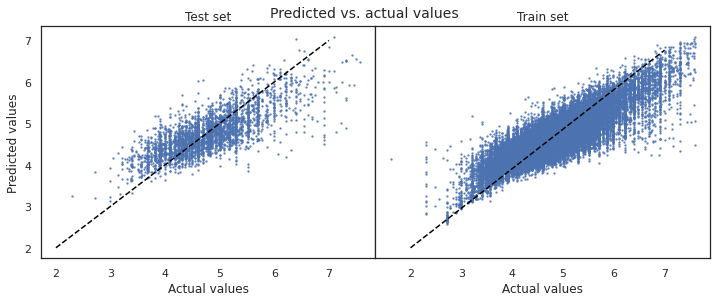

In [42]:
model_evaluation(xgb_best)

In [43]:
ft_weights_xgb = pd.DataFrame(xgb_best.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb.sort_values('weight', inplace=True)
ft_weights_xgb

,weight
secure,0.005889
Sentiment_intensity,0.006063
host_identity_verified_t,0.006294
breakfast,0.006311
cancellation_policy_moderate,0.006355
pets_allowed,0.007234
Description_Length,0.007249
topic_general,0.007482
check_in_24h,0.007493
host_response_rate_50-89%,0.007700


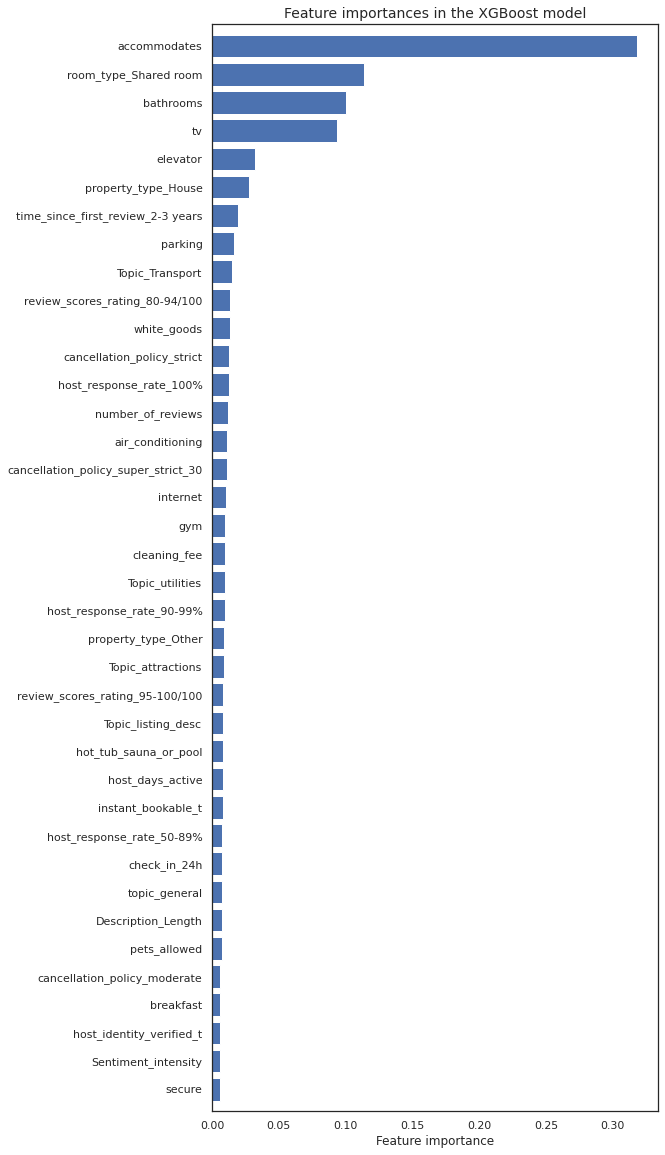

In [44]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb.index, ft_weights_xgb.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()


# We know the tentative performance now, lets build the model on entire training to make prediction on test/production


In [45]:
xtrain=cleaned_train_data.drop('log_price',axis=1)
ytrain=cleaned_train_data['log_price']

In [ ]:
xgb=XGBRegressor(objective ='reg:squarederror', random_state=42)
final_model=RandomizedSearchCV(xgb,param_distributions=xgb_params,cv=10,n_iter=20,scoring='neg_root_mean_squared_error',
                                 n_jobs=-1,verbose=False)
                                 
 

In [ ]:
final_model.fit(xtrain,ytrain)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=42, re...
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4,
                           

In [ ]:
test_preds=final_model.predict(cleaned_test_data)

In [ ]:

import xlsxwriter
data_sub=pd.DataFrame(test_preds, index=test_data.index, columns=['log_price'])
writer = pd.ExcelWriter('output.xlsx', engine='xlsxwriter')
data_sub.to_excel(writer,sheet_name='Sheet1')
writer.save()


# Building a neural network
   

   ### Model 2:  neural network with L1 regularization and  epochs

In [46]:
# Building the model
model2 = models.Sequential()
model2.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model2.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model2.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model2.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model2.add(layers.Dense(1, activation='linear'))

# Compiling the model
model2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
model2.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4992      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 235,905
Trainable params: 235,905
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Training the model
model2_start = time.time()

history = model2.fit(X_train,
                  y_train,
                  epochs=250,
                  batch_size=300,
                  validation_split = 0.1)

model2_end = time.time()

print(f"Time taken to run: {round((model2_end - model2_start)/60,1)} minutes")

Epoch 1/250
140/140 [==============================] - 1s 4ms/step - loss: 31.0612 - mean_squared_error: 1.1883 - val_loss: 12.4560 - val_mean_squared_error: 0.3342
Epoch 2/250
140/140 [==============================] - 0s 3ms/step - loss: 7.4346 - mean_squared_error: 0.3113 - val_loss: 4.1721 - val_mean_squared_error: 0.2780
Epoch 3/250
140/140 [==============================] - 0s 3ms/step - loss: 2.7930 - mean_squared_error: 0.2789 - val_loss: 1.8001 - val_mean_squared_error: 0.2639
Epoch 4/250
140/140 [==============================] - 0s 3ms/step - loss: 1.3326 - mean_squared_error: 0.2811 - val_loss: 0.9713 - val_mean_squared_error: 0.2727
Epoch 5/250
140/140 [==============================] - 0s 3ms/step - loss: 0.8111 - mean_squared_error: 0.2851 - val_loss: 0.6687 - val_mean_squared_error: 0.2713
Epoch 6/250
140/140 [==============================] - 0s 3ms/step - loss: 0.6133 - mean_squared_error: 0.2823 - val_loss: 0.5463 - val_mean_squared_error: 0.2677
Epoch 7/250
140/140 

# Function to evaluate the model

In [48]:
def model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training RMSE:", round(np.sqrt(mean_squared_error(y_train, y_train_pred)),4))
    print("Validation RMSE:", round(np.sqrt(mean_squared_error(y_test, y_test_pred)),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training RMSE: 0.5002
Validation RMSE: 0.499

Training r2: 0.5128
Validation r2: 0.5222


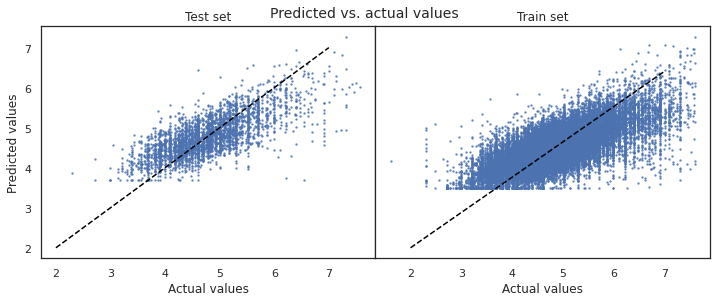

In [49]:
# Evaluating the model
model_evaluation(model2, skip_epochs=2)

This NN has performed better than the previous model, and about as well as the XGBoost model. It has also removed the overfitting issue, as train and test sets are performing the same

In [50]:
#Training the model
model2_start = time.time()

model2.fit(xtrain,ytrain,epochs=250,batch_size=300,validation_split = 0.1)
model2_end = time.time()

print(f"Time taken to run: {round((model2_end - model2_start)/60,1)} minutes")

Epoch 1/250
150/150 [==============================] - 1s 4ms/step - loss: 23.6610 - mean_squared_error: 22.1919 - val_loss: 1.6341 - val_mean_squared_error: 0.5048
Epoch 2/250
150/150 [==============================] - 0s 3ms/step - loss: 1.3546 - mean_squared_error: 0.5163 - val_loss: 1.1093 - val_mean_squared_error: 0.4914
Epoch 3/250
150/150 [==============================] - 0s 3ms/step - loss: 1.0294 - mean_squared_error: 0.5142 - val_loss: 0.9279 - val_mean_squared_error: 0.4896
Epoch 4/250
150/150 [==============================] - 0s 3ms/step - loss: 0.9054 - mean_squared_error: 0.5144 - val_loss: 0.8356 - val_mean_squared_error: 0.4872
Epoch 5/250
150/150 [==============================] - 0s 3ms/step - loss: 0.8315 - mean_squared_error: 0.5138 - val_loss: 0.7783 - val_mean_squared_error: 0.4878
Epoch 6/250
150/150 [==============================] - 0s 3ms/step - loss: 0.7823 - mean_squared_error: 0.5135 - val_loss: 0.7395 - val_mean_squared_error: 0.4870
Epoch 7/250
150/150 

In [51]:
prediction=model2.predict(cleaned_test_data)

In [54]:
import xlsxwriter
data_sub=pd.DataFrame(prediction, index=test_data.index, columns=['log_price'])
writer = pd.ExcelWriter('output_NN.xlsx', engine='xlsxwriter')
data_sub.to_excel(writer,sheet_name='Sheet1')
writer.save()

# Final model selection
Overall, the XGBoost model (Model 1) is the preferred model, which performs ever so slightly better than the best neural network  and is less computationally expensive. It could possibly be improved further with hyper-parameter tuning.